# 1. Import and Install Dependencies

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf

from PIL import ImageFont, ImageDraw, Image


In [2]:
seed=42
np.random.seed(seed)
tf.random.set_seed(seed)

font = ImageFont.truetype('fonts/gulim.ttc', 30)
colors = [(245,117,16), (117,245,16), (16,117,245), (255,227,79), (254,218,249)]

def prob_viz(res, actions, sentence, input_frame, colors):
    output_frame = input_frame.copy()
    
    # show prob
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
    
    # show text box
    cv2.rectangle(output_frame, (0,0), (640, 40), (245, 117, 16), -1) # 텍스트박스
    
    # show sentence text
    output_frame = Image.fromarray(output_frame)
    draw = ImageDraw.Draw(output_frame)
    draw.text( (3,3) , ' '.join(sentence), font=font, fill= (255,255,255))
    
    # show prob text
    for num, prob in enumerate(res):
        draw.text((0, 60+num*40), actions[num], font=font, fill= (255,255,255))

        
    return np.array(output_frame)



In [3]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction. Model : holistic, image를 입력해 스켈레톤을 좌표값을 생성.
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [5]:
# 입력 image에 landmarks 얹는 함수.
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [6]:
def draw_styled_landmarks(image, results):
    # image : frame, results : model.predict(image)
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [7]:
# 함수화 : 각 좌표값을 한 ndarray로 concat.
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# 2. Preprocess Data and Create Labels and Features

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [9]:
# Path
DATA_PATH = os.path.join('./Data/handmade') 

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

actions = np.array(['나', '목', '아프다', '병원', '어디'])
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'나': 0, '목': 1, '아프다': 2, '병원': 3, '어디': 4}

In [10]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])
        
X = np.array(sequences)
y = to_categorical(labels).astype(int)

print(f'X shape : {X.shape}')
print(f'y shape : {y.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
print(f'Train shape : {X_train.shape, y_train.shape}')
print(f'Test shape : {X_test.shape, y_test.shape}')

X shape : (150, 30, 1662)
y shape : (150, 5)
Train shape : ((142, 30, 1662), (142, 5))
Test shape : ((8, 30, 1662), (8, 5))


# 3. Build and Train LSTM Neural Network

In [20]:
log_dir = os.path.join('Logs2')
tb_callback = TensorBoard(log_dir=log_dir)

In [21]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [22]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [23]:
model.fit(X_train, y_train, epochs=80, callbacks=[tb_callback])

Epoch 1/80
5/5 [==============================] - 3s 63ms/step - loss: 5.6887 - categorical_accuracy: 0.1479
Epoch 2/80
5/5 [==============================] - 0s 67ms/step - loss: 10.8656 - categorical_accuracy: 0.2183
Epoch 3/80
5/5 [==============================] - 0s 63ms/step - loss: 4.6647 - categorical_accuracy: 0.2254
Epoch 4/80
5/5 [==============================] - 0s 61ms/step - loss: 5.0092 - categorical_accuracy: 0.2465
Epoch 5/80
5/5 [==============================] - 0s 62ms/step - loss: 6.4778 - categorical_accuracy: 0.1831
Epoch 6/80
5/5 [==============================] - 0s 72ms/step - loss: 2.0117 - categorical_accuracy: 0.1761
Epoch 7/80
5/5 [==============================] - 0s 62ms/step - loss: 1.5835 - categorical_accuracy: 0.3169
Epoch 8/80
5/5 [==============================] - 0s 64ms/step - loss: 1.5668 - categorical_accuracy: 0.3099
Epoch 9/80
5/5 [==============================] - 0s 61ms/step - loss: 1.5026 - categorical_accuracy: 0.3732
Epoch 10/80
5/5 [=

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 5)                 165       
                                                                 
Total params: 596,741
Trainable params: 596,741
Non-tr

# 7. Save Weights

In [11]:
model.save('second.h5')

NameError: name 'model' is not defined

In [22]:
del model

In [12]:
model = tf.keras.models.load_model('second.h5')

# 8. Evaluation using Confusion Matrix and Accuracy

In [13]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, classification_report

In [14]:
yhat = model.predict(X_test)
yhat = np.argmax(yhat, axis=1).tolist()

ytrue = np.argmax(y_test, axis=1).tolist()

In [15]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[7, 0],
        [0, 1]],

       [[7, 0],
        [0, 1]],

       [[4, 0],
        [0, 4]],

       [[7, 0],
        [0, 1]],

       [[7, 0],
        [0, 1]]], dtype=int64)

In [16]:
print(confusion_matrix(ytrue, yhat))
print(classification_report(ytrue, yhat))

[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 4 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



# 11. Test in Real Time

In [ ]:
from PIL import ImageFont, ImageDraw, Image
font = ImageFont.truetype('fonts/gulim.ttc', 30)
colors = [(245,117,16), (117,245,16), (16,117,245), (255,227,79), (254,218,249)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    
    for num, prob in enumerate(res):
        
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        
    output_frame = Image.fromarray(output_frame)
    draw = ImageDraw.Draw(output_frame)

    for num, prob in enumerate(res):
        draw.text((0, 60+num*40), actions[num], font=font, fill= (255,255,255))
    
        
    return output_frame


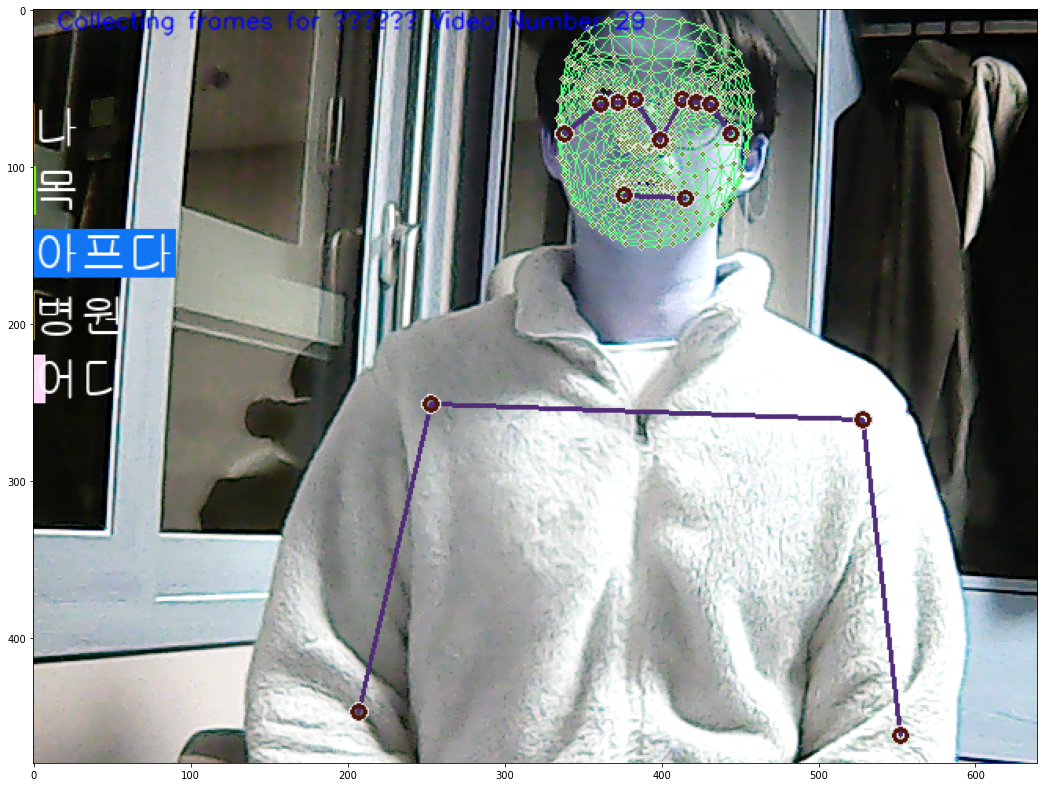

In [119]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res[0], actions, image, colors))

In [17]:
# 1. New detection variables

sequence = [] # 마지막 30프레임 저장
sentence = [] # 표출어 리스트
threshold = 0.8 # prob 0.8 이상일 때 출력

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarksq
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0] # output shape : (1,3)
            print(actions[np.argmax(res)]) # print text
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: # 확률 80% 이상일 때 텍스트 추가.
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]: # 이전 텍스트와 다를 때 새로 추가
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)]) # 첫글자는 그냥 추가

            if len(sentence) > 5: # 문자가 5개를 초과하면 앞 문자열 삭제
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, sentence, image, colors) # prob bar를 image에 얹기.
            
        
        # 텍스트 박스
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.S

<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>

<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>

<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>

<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>
나
<class 'mediapipe.python.solution_base.SolutionOutputs'>

<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>

<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>

목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs'>
목
<class 'mediapipe.python.solution_base.SolutionOutputs

병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_base.SolutionOutputs'>
병원
<class 'mediapipe.python.solution_bas

In [48]:
cap.release()
cv2.destroyAllWindows()

In [85]:
res[np.argmax(res)] > threshold

True

In [16]:
sentence

['병원', '나', '목', '나', '목']